# A wheel rolling on a floor driven by a torque
© 2023 @RR_Inyo<br/>
Released under the MIT license<br/>
https://opensource.org/licenses/mit-license.php

## Introduction
This notebook solves the motion equation of a wheel driven by a torque using scipy.integrate.solve_ivp function.

See the model below. $M$ and $J$ are the mass and inertia of the wheel, respectively. $a$ is the radius.
<figure><img src="wheel-model.png" style="zoom:0.5;"><figcaption>Fig. 1 Model of a wheel</figcaption></figure>
This is a wheel rolling on a floor driven by a torque by an external energy source. $x_{w}$ and $v_{w}$ are the $x$-axis position and velocity of the wheel, respectively whereas $\theta$ and $\omega$ is the angle and angular speed of the wheel, respectively. No slipping is assumed, which means the $x$-axis translational speed $v_{w}$ and the angular speed of the wheel $\omega$ is restrained.
$$
a \omega = v_{w} \tag{1}
$$
Under this retraint condition, the motion equation can be written as follows:
$$
\begin{align}
\dot{x}_{w} &= v_{w} \\[5pt]
\dot{v}_{w} &= \displaystyle \frac{\tau}{M a + \displaystyle \frac{J}{a}}
\end{align} \tag{2}
$$

In this example notebook, the torque is applied in a state-feedback manner to control the wheel's $x$-axis position at $x = -2$ m ($1 \leq t < 6$) and $x = 2$ m ($t \geq 6$).

The motion equation is solved by SciPy (scipy.integrate.solve_ivp function) and visualized/animated by Matplotlib.

## Solve the motion equation by SciPy
From here, the motion equation in (2) is implemented as a Python's function and solve by SciPy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
from IPython.display import HTML

In [2]:
# Control torque calculation
# State y = [x_w, v_w]
def getTorque(t, y):
    if t < 1:
        tau = 0
    elif 1 <= t < 6:
        tau = F[0] * (y[0] + 2) + F[1] * y[1]
    else:
        tau = F[0] * (y[0] - 2) + F[1] * y[1]
    return tau

In [3]:
# Define wheel ODE
# State y = [x_w, v_w]
def func(t, y):
    # Torque
    _tau = getTorque(t, y)

    dydt = np.zeros_like(y)
    dydt[0] = y[1]            # position is integral of velocity
    dydt[1] = _tau / (M * a + J / a)
    return dydt

In [4]:
# Conditions
M = 5                     # Mass, kg
a = 0.25                  # Radius, m
J = M * a**2 / 2          # Inertia, disc

In [5]:
# Controller, state feedback gain
F = np.array([-4, -5])
tau_max = 100

In [6]:
# Solve
dt = 0.001
t = np.arange(0.0, 12.0, dt)
x_w0 = np.array([0, 0])

sol = solve_ivp(func, [0, 12], x_w0, t_eval = t)

## Postprosessing and time-domain plotting
The solution `sol` is an instance of a specialized class to contain the solution. `sol.t` is the time as a NumPy array while `sol.y` contains the solution itself. To make it easy to handle the solution, the position $x_{w}$ and velocity $v_{w}$ are extracted from `sol.y`.

In [7]:
# Postprocessing
x_w = sol.y[0,:]
v_w = sol.y[1,:]
theta = ((x_w / a) + np.pi) % (2 * np.pi) - np.pi

The signal of the torque is reproduced from the obtained solution because it is now impossible to directly obtain it during the execution of the scipy.integrate.solve_ivp function.

In [8]:
# Reproduce torque waveform
tau = np.zeros_like(t)
for i, _t in enumerate(t):
    tau[i] = getTorque(_t, sol.y[:,i])

The time-domain plotting is made by Matplotlib below.

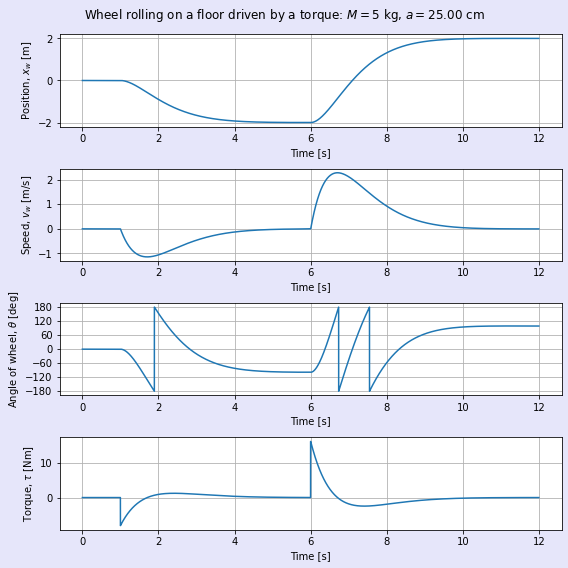

In [9]:
# Time-domain plots
fig, ax = plt.subplots(4, 1, figsize = (8, 8))
fig.patch.set_facecolor('lavender')
fig.suptitle(f'Wheel rolling on a floor driven by a torque: $M = {M}$ kg, $a = {a * 100:.2f}$ cm')

# Plot position
ax[0].plot(t, x_w)
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Position, $x_{w}$ [m]')
ax[0].grid()

# Plot speed
ax[1].plot(t, v_w)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Speed, $v_{w}$ [m/s]')
ax[1].grid()

# Plot angle
ax[2].plot(t, np.degrees(theta))
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('Angle of wheel, $\\theta$ [deg]')
ax[2].set_yticks(range(-180, 240, 60))
ax[2].grid()

# Plot torque
ax[3].plot(t, tau)
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Torque, $\\tau$ [Nm]')
ax[3].grid()

fig.tight_layout()

## Visualization/Animation
To make the solution more understandable, now the animation is made by Matplotlib.

In [10]:
# Animation plot settings
floor_begin = -6
floor_end = 6

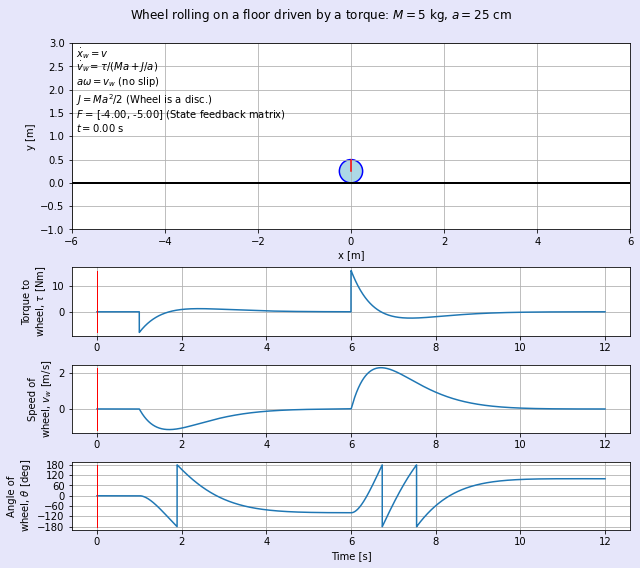

In [11]:
# Create "theatre" of animation
#plt.rcParams["font.size"] = 14
fig, ax = plt.subplots(4, 1, figsize = (9, 8), gridspec_kw={'height_ratios': [3, 1, 1, 1]})
fig.patch.set_facecolor('lavender')
ax[0].set_aspect('equal')
fig.suptitle(f'Wheel rolling on a floor driven by a torque: $M = {M}$ kg, $a = {int(a * 100)}$ cm')

# Set axes
ax[0].set_xlim(floor_begin, floor_end)
ax[0].set_xlabel('x [m]')
ax[0].set_ylim(-1, 3)
ax[0].set_ylabel('y [m]')
ax[0].grid()

# Draw floor
ax[0].plot([floor_begin, floor_end], [0, 0], lw = 2, color = 'black')

# Draw motion equation
ax[0].text(floor_begin + 0.1, 2.7, r'$\dot{x}_{w} = v$')
ax[0].text(floor_begin + 0.1, 2.4, r'$\dot{v}_{w} = \tau / (M a + J / a)$')
ax[0].text(floor_begin + 0.1, 2.1, r'$a \omega = v_{w}$ (no slip)')
ax[0].text(floor_begin + 0.1, 1.7, r'$J = M a^2 / 2$ (Wheel is a disc.)')
# ax[0].text(floor_begin + 0.1, 1.7, r'$J = M a^2$ (Wheel is a ring.)')
ax[0].text(floor_begin + 0.1, 1.4, f'$F$ = [{F[0]:.2f}, {F[1]:.2f}] (State feedback matrix)')
text_time = ax[0].text(floor_begin + 0.1, 1.1, f'$t = {t[0]:.2f}$ s')

# Draw wheel
wheel = patches.Circle(xy = (x_w[0], a), radius = a, lw = 1.5, ec = 'blue', fc = 'lightblue')
ax[0].add_patch(wheel)

# Draw wheel angle marker
[line_angle] = ax[0].plot([x_w[0], x_w[0] - a * np.sin(theta[0])], [a, a + a * np.cos(theta[0])], lw = 1.5, c = 'red')

# Plot position
ax[1].plot(t, tau)
ax[1].set_ylabel('Torque to\nwheel, $\\tau$ [Nm]')
[line_time_1] = ax[1].plot([t[0], t[0]], [np.min(tau), np.max(tau)], lw = 1, c = 'red') 
ax[1].grid()

# Plot position
ax[2].plot(t, v_w)
ax[2].set_ylabel('Speed of\nwheel, $v_{w}$ [m/s]')
[line_time_2] = ax[2].plot([t[0], t[0]], [np.min(v_w), np.max(v_w)], lw = 1, c = 'red') 
ax[2].grid()

# Plot angle
ax[3].plot(t, np.degrees(theta))
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Angle of\nwheel, $\\theta$ [deg]')
ax[3].set_yticks(range(-180, 240, 60))
[line_time_3] = ax[3].plot([t[0], t[0]], [-180, 180], lw = 1, c = 'red') 
ax[3].grid()

fig.tight_layout()

In [12]:
# Function to update
def animate(i):
    # Update wheel position
    wheel.center = (x_w[i], a)
    
    # Update wheel angle marker
    line_angle.set_data([x_w[i], x_w[i] + a * np.sin(theta[i])], [a, a + a * np.cos(theta[i])])
    
    # Update time text
    text_time.set_text(f'$t = {t[i]:.2f}$ s')
    
    # # Update time bars
    line_time_1.set_data([t[i], t[i]], [np.min(tau), np.max(tau)])
    line_time_2.set_data([t[i], t[i]], [np.min(v_w), np.max(v_w)])
    line_time_3.set_data([t[i], t[i]], [-180, 180])
    
    return (wheel, line_angle, line_time_1, line_time_2, line_time_3)

Using the functionality of IPython.HTML, you can embed the animation in the notebook (in the browser). To do so, you need to install FFmpeg to create an HTML5 mp4 video.

In [13]:
# Create animation
ani = animation.FuncAnimation(fig, animate, \
    frames = np.arange(0, len(t), 50), interval = (t[1] - t[0]) * 50 * 1000, blit = True)

# Show animation as an HTML5 video in the notebook
HTML(ani.to_html5_video())

You can also save the animation as an animation GIF file.

In [14]:
# Save 
ani.save('wheel_controlled.gif')

Fig. 2 below is the saved GIF file.
<figure><img src="wheel_controlled.gif"><figcaption>Fig. 2 Generated animation GIF file</figcaption></figure?